In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


# Flowers Dataset and VGG Features

![image.png](attachment:image.png)

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


In [ ]:
import scipy
scipy.sparse.issparse(f_all)

False

In [ ]:
f_all

array([[-2.80316663, -2.75858927, -1.85059488, ..., -3.68159294,
         2.2887187 , -0.06022811],
       [-0.43915609,  0.03041166,  1.6122117 , ..., -3.72905087,
        -1.91476536, -2.32046223],
       [-2.66422653, -1.4850831 , -1.08928919, ..., -1.12573397,
        -0.14623994,  1.70590079],
       ...,
       [-0.48330939, -3.99659586,  3.89438701, ..., -5.0488205 ,
         1.52318549, -3.94225597],
       [ 1.07260156, -0.66473222,  2.13156581, ..., -3.22082138,
         0.14532563,  0.67761904],
       [-1.71976674,  0.9036842 , -0.18791535, ..., -5.29169655,
        -1.00260162,  3.04216123]])

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


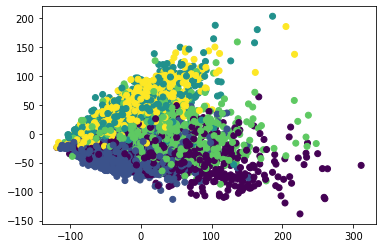

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# MLP Classifier

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
              optimizer.zero_grad()
              outputs = self.foward(X_)
              loss = criterion(outputs, y_)
              loss.backward()
              optimizer.step()

        return self
    
    def eval(self, X_test, y_test):
      criterion = nn.NLLLoss()
      loss = criterion(X_test, y_test)
      return loss

# Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


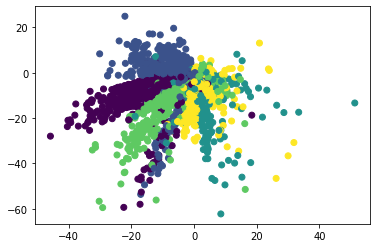

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

In [ ]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(f_all)
print(embedding.shape)

(3670, 2)


Text(0.5, 1.0, 't-SNE')

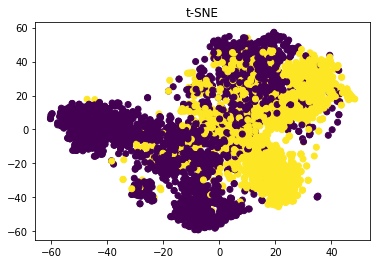

In [ ]:
colors = []
for y in y_all:
  if y < 3:
    colors.append(0)
  else:
    colors.append(1)
  
plt.scatter(embedding[:,0], embedding[:,1], c = colors)
plt.title("t-SNE")


Question #24

In [ ]:
!pip install umap-learn
import umap.umap_ as umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=120daa4f4f899d8f73fb58b1b8ab364b3fbe42edb97791a523bf6669bebc96bb
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=7e26283ff7b0a432faf871dc7edb0bb97961f0d96b66541df91cb112b55eb4c8
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF

In [ ]:
svd = TruncatedSVD(n_components=50)
umap_cos = umap.UMAP(n_components=50, metric='cosine')
X_em =Autoencoder(50)

kmeans = KMeans(n_clusters=5, max_iter = 5000, n_init = 30, random_state=0)
agglo_ward = AgglomerativeClustering(n_clusters=5, linkage='ward')

In [ ]:
svd_f = svd.fit_transform(f_all)
umap_cos_f = umap_cos.fit_transform(f_all)
x_em_f = X_em.fit_transform(f_all)

100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


In [ ]:
kmeans_svd = kmeans.fit(svd_f)
kmeans_umap = kmeans.fit(umap_cos_f)
kmeans_x_em = kmeans.fit(x_em_f)

agglo_svd = agglo_ward.fit(svd_f)
agglo_umap = agglo_ward.fit(umap_cos_f)
agglo_x_em = agglo_ward.fit(x_em_f)

In [ ]:
print("SVD + Kmeans RAND SCORE : ", adjusted_rand_score(y_all, kmeans_svd.labels_))
print("UMAP + Kmeans RAND SCORE : ", adjusted_rand_score(y_all, kmeans_umap.labels_))
print("Auto Encoder + Kmeans RAND SCORE : ", adjusted_rand_score(y_all, kmeans_x_em.labels_))

print("SVD + Agglo RAND SCORE : ", adjusted_rand_score(y_all, agglo_svd.labels_))
print("UMAP + Agglo RAND SCORE : ", adjusted_rand_score(y_all, agglo_umap.labels_))
print("Auto Encoder + Agglo RAND SCORE : ", adjusted_rand_score(y_all, agglo_x_em.labels_))

SVD + Kmeans RAND SCORE :  0.17562066429455486
UMAP + Kmeans RAND SCORE :  0.17562066429455486
Auto Encoder + Kmeans RAND SCORE :  0.17562066429455486
SVD + Agglo RAND SCORE :  0.23059058817884576
UMAP + Agglo RAND SCORE :  0.23059058817884576
Auto Encoder + Agglo RAND SCORE :  0.23059058817884576


In [ ]:
eps_rec = []
min_samples_rec = []
db_hs = []
db_cs = []
db_vs = []
db_ari = []
db_ms = []

eps = [0.01, 0.1,1.0,5.0,10.0,50.0]
min_samples = [5,15,30,60,100,200,500]

for ep in eps:
    for samp in min_samples:
      dbs = DBSCAN(eps=ep,min_samples=samp)
      dbs_svd = agglo_ward.fit(svd_f)
      dbs_umap = agglo_ward.fit(umap_cos_f)
      dbs_x_em = agglo_ward.fit(x_em_f)
      print(f'--- EP: {ep} & Min Sample = {samp}---')
      print("SVD + DBSCAN RAND SCORE : ", adjusted_rand_score(y_all, dbs_svd.labels_))
      print("UMAP + DBSCAN RAND SCORE : ", adjusted_rand_score(y_all, dbs_umap.labels_))
      print("Auto Encoder + DBSCAN RAND SCORE : ", adjusted_rand_score(y_all, dbs_x_em.labels_))

--- EP: 0.01 & Min Sample = 5---
SVD + DBSCAN RAND SCORE :  0.23059058817884576
UMAP + DBSCAN RAND SCORE :  0.23059058817884576
Auto Encoder + DBSCAN RAND SCORE :  0.23059058817884576
--- EP: 0.01 & Min Sample = 15---
SVD + DBSCAN RAND SCORE :  0.23059058817884576
UMAP + DBSCAN RAND SCORE :  0.23059058817884576
Auto Encoder + DBSCAN RAND SCORE :  0.23059058817884576
--- EP: 0.01 & Min Sample = 30---
SVD + DBSCAN RAND SCORE :  0.23059058817884576
UMAP + DBSCAN RAND SCORE :  0.23059058817884576
Auto Encoder + DBSCAN RAND SCORE :  0.23059058817884576
--- EP: 0.01 & Min Sample = 60---
SVD + DBSCAN RAND SCORE :  0.23059058817884576
UMAP + DBSCAN RAND SCORE :  0.23059058817884576
Auto Encoder + DBSCAN RAND SCORE :  0.23059058817884576
--- EP: 0.01 & Min Sample = 100---
SVD + DBSCAN RAND SCORE :  0.23059058817884576
UMAP + DBSCAN RAND SCORE :  0.23059058817884576
Auto Encoder + DBSCAN RAND SCORE :  0.23059058817884576
--- EP: 0.01 & Min Sample = 200---
SVD + DBSCAN RAND SCORE :  0.23059058817

Question #25